## Семантическая сегментация

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net либо на другом датасете либо с другим бэкбоном (другой свёрточной частью). 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>

In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8145286004860125438
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12653676259872091120
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
# !pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf

In [4]:
!apt remove git -y
!apt-get install git -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git
0 upgraded, 0 newly installed, 1 to remove and 24 not upgraded.
After this operation, 36.6 MB disk space will be freed.
(Reading database ... 122306 files and directories currently installed.)
Removing git (1:2.25.1-1ubuntu3.10) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,534 kB of archives.
After this operation, 36.6 MB of additional disk space will be used.
Get:1 http://archive

In [12]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [10]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [11]:
# from tensorflow.examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Загрузка датасета 

Датасет является стандартным датасетом для TensorFlow, однако как упомяналось выше возможно необходимо будет установить модуль tensorflow-datasets для python.

In [14]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [15]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [16]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [17]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому давайте использовать их.

In [18]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [20]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Давайте посмотрим на пример  изображения из датасета и соотвествующую ему маску из датасета.

In [21]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

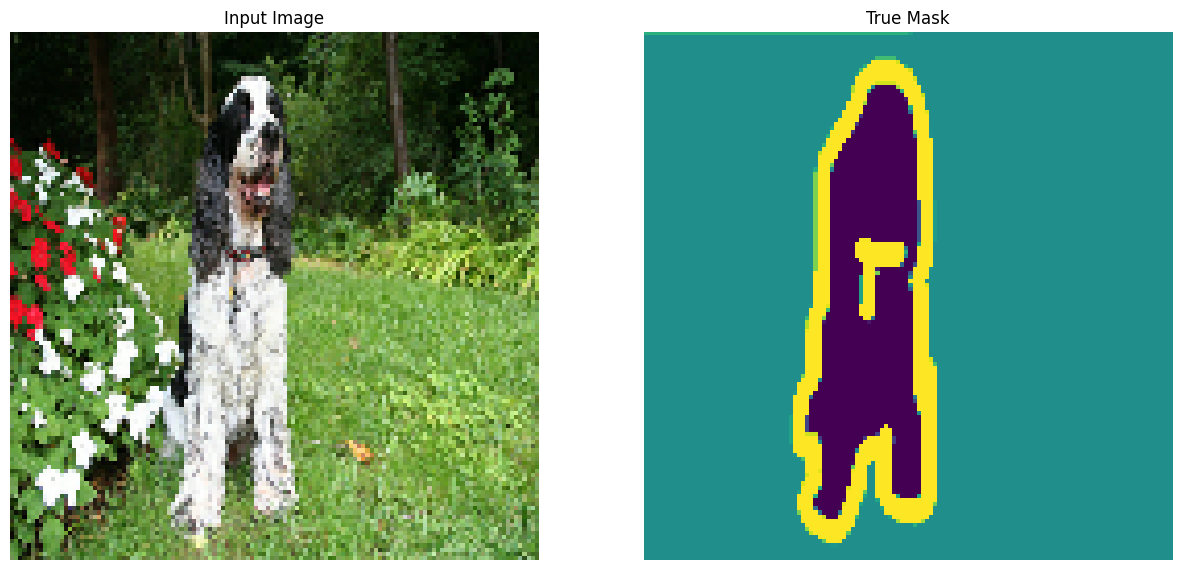

In [37]:
for image, mask in train.take(2):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный VGG16.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

In [23]:
OUTPUT_CHANNELS = 3

In [24]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=[128, 128, 3])
# Use the activations of these layers
layer_names = [
    'block1_conv2',   # 128x128 64
    'block2_conv2',   # 64x64 128
    'block3_conv3',   # 32x32 256
    'block4_conv3',   # 16x16 512
    'block5_conv3',  # 8x8 512
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [26]:
# VGG16 v1
up_stack = [
    pix2pix.upsample(256, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs
  skips = down_stack(x)
  #concat = tf.keras.layers.Concatenate()
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides = (2, 2))(skips[4])
  x = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.BatchNormalization(x)

  x = up_stack[0](x)
  x = tf.keras.layers.Concatenate()([x, skips[4]])
  x = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.BatchNormalization(x)

  x = up_stack[1](x)
  x = tf.keras.layers.Concatenate()([x, skips[3]])
  x = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.BatchNormalization(x)

  x = up_stack[2](x)
  x = tf.keras.layers.Concatenate()([x, skips[2]])
  x = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.BatchNormalization(x)

  x = up_stack[3](x)
  x = tf.keras.layers.Concatenate()([x, skips[1]])
  x = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.BatchNormalization(x)

  x = up_stack[4](x)
  x = tf.keras.layers.Concatenate()([x, skips[0]])
  x = tf.keras.layers.Conv2D(3, 3, strides=(1, 1), padding='same', activation='relu')(x)
  #x = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
# VGG16 v2

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),   # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips)
  # После послеенего скипа не забываем max pool и conv как в схеме Тернауса
  max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides = (2, 2))
  conv = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='relu')
  
  x = max_pool(x)
  x = conv(x)

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2D(3, 1, strides=1, padding='same')  #128x128x128 -> 128x128x3

  x = last(x)
  #x = tf.math.sigmoid(x, name=None)
  return tf.keras.Model(inputs=inputs, outputs=x)

## Тренировка модели

In [28]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

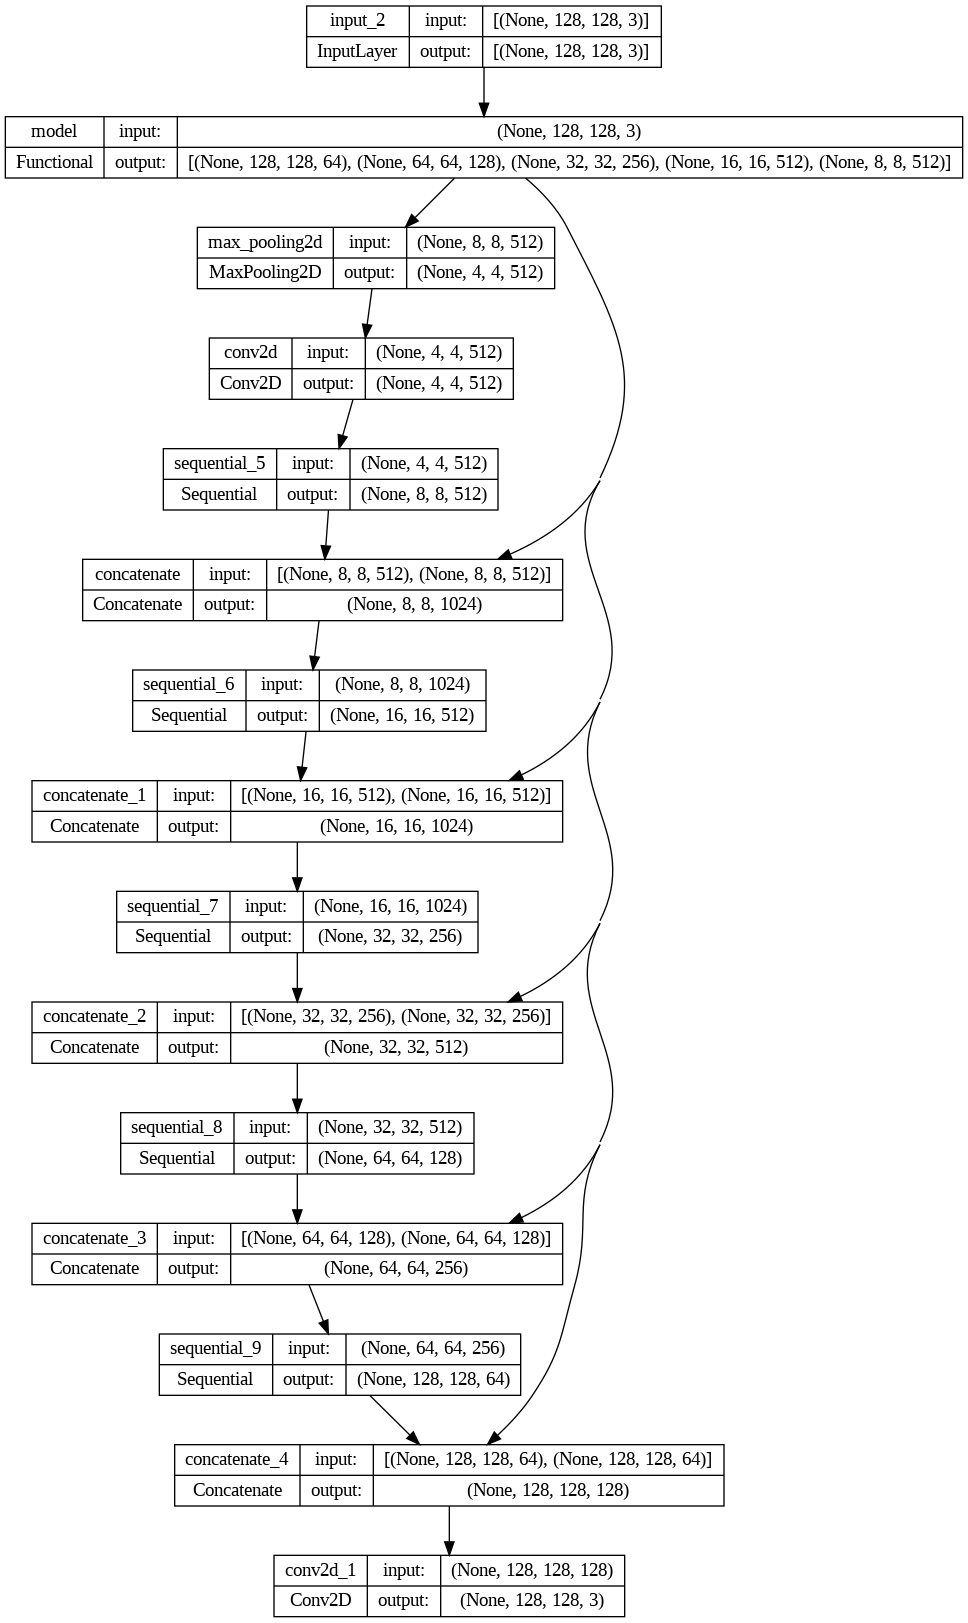

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [31]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 63ms/step


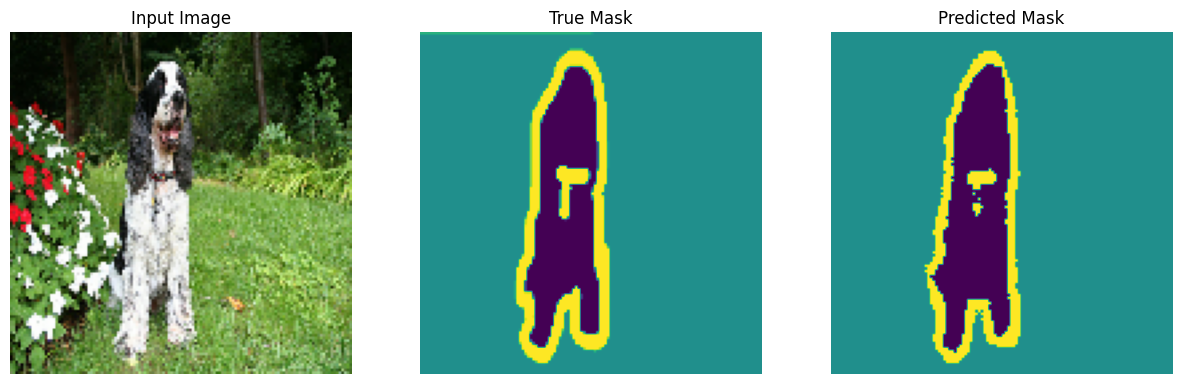

In [38]:
show_predictions(num=2)

Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 34ms/step


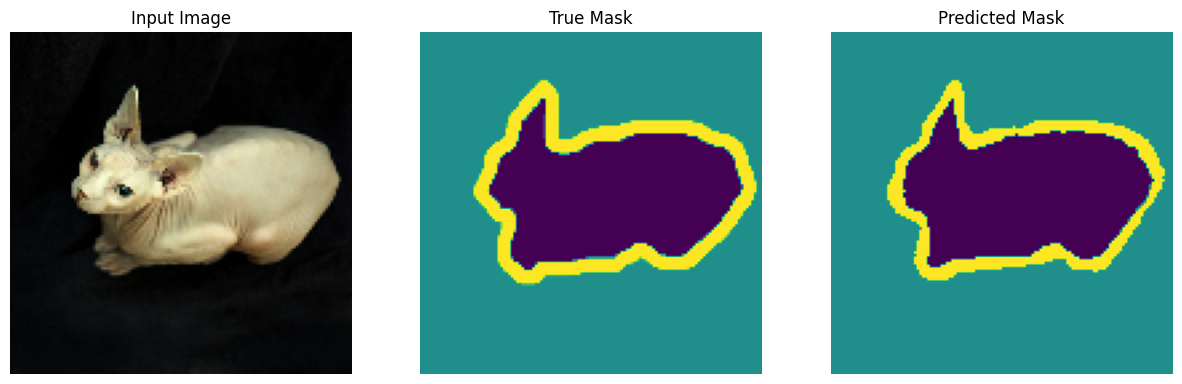


Sample Prediction after epoch 30

28/28 [==============================] - 31s 1s/step - loss: 0.0863 - accuracy: 0.9581 - val_loss: 0.5119 - val_accuracy: 0.8623


In [34]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

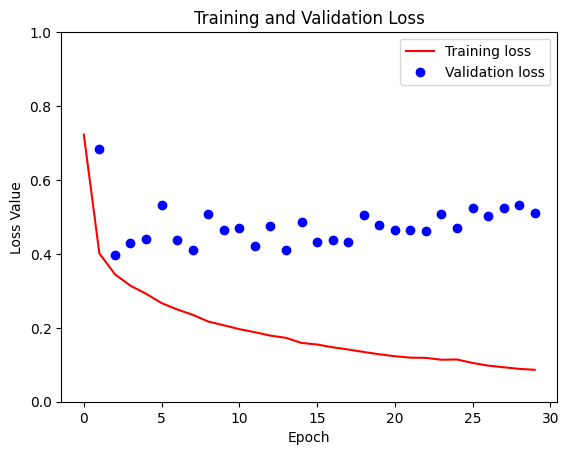

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Предсказание


Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

4/4 [==============================] - 0s 125ms/step


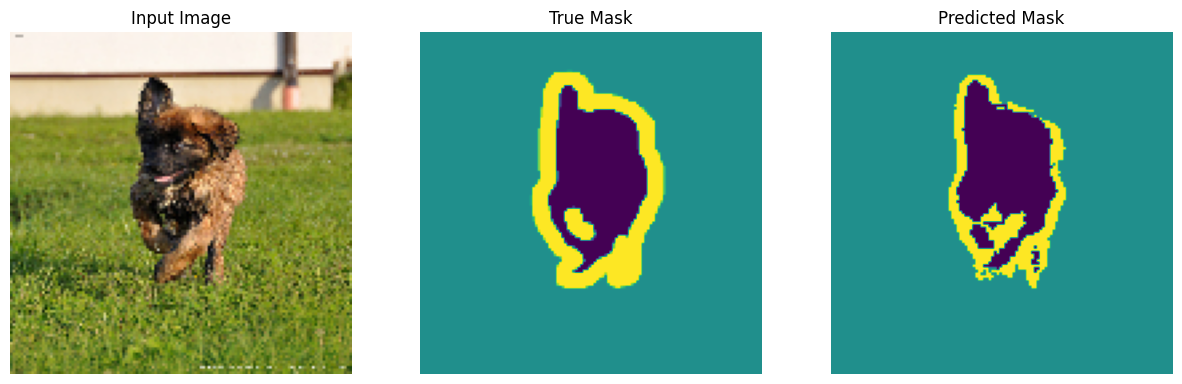

In [41]:
show_predictions(test_dataset, num=1)